In [1]:
! pip install numpy
! pip install matplotlib
! pip install wfdb
! pip install scipy
! pip install ipywidgets


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ECG Read & Zeropadding

In [2]:
import wfdb
import matplotlib as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os

In [3]:
# 현재 경로 불러오기 = os.getcwd()
path = os.getcwd()
os.chdir(path+ "\\training2017")
print(os.getcwd())

d:\Code Works\Work\vs code\ecg project\Spectrogram\training2017


In [4]:
csv='REFERENCE.csv'
data = pd.read_csv(csv, header=None, names=['ID', 'Label'])

In [5]:
A =[] # Atrial Fibrillation
N= [] # Normal Sinus rhythm
O = [] # Other rhythm
I = [] # Noisy

for id, lb in zip (data['ID'], data['Label'] ): #v2 data
         
         if lb =='A':
            A.append(id)
            
         elif lb =='N':
            N.append(id)
         
         elif lb =='O':
            O.append(id)
        
         elif lb =='~':
            I.append(id)   

In [6]:
dic = {'Atrial Fibrillation': A, 'Normal Sinus Rhythm': N, 'Other Rhythm': O, 'Noisy': I}

## ECG read function

In [7]:
def ecg_read(patient_id):
    record = wfdb.rdrecord(patient_id) 
    ecg_signal = record.p_signal[:,0]  
    fs = record.fs
    return ecg_signal, fs

## 최대시간

In [8]:
record = wfdb.rdrecord('A05736')
ecg_signal = record.p_signal[:,0]  # time sequencial == ts
fs = record.fs
        
maxtime = np.arange(0,len(ecg_signal) )/fs
maxtime_length = len(maxtime) # 18286

In [9]:
ecg_signal, fs = ecg_read('A00001')

## RR Interval 계산 및 HeartRate 계산

In [10]:
import wfdb
import numpy as np
from scipy.signal import find_peaks

def calculate_hr_from_ecg(ecg_signal, fs):
    # R파 검출
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6)  # R파는 일반적으로 초당 최대 1회 발생

    # RR 간격 계산 (단위: 초)
    rr_intervals = np.diff(peaks) / fs

    # 평균 심박수 계산
    avg_hr = 60 / np.mean(rr_intervals)

    return avg_hr

hr = calculate_hr_from_ecg(ecg_signal, fs)
print("Estimated Heart Rate:", hr, "BPM")

Estimated Heart Rate: 78.7746170678337 BPM


## Zero padding

In [11]:
# zero pading function
def extend_ts(ecg_signal, length):
    extended = np.zeros(length)
    siglength = np.min([length, ecg_signal.shape[0]])
    extended[:siglength] = ecg_signal[:siglength]
    return extended 

# Pt Algorithm filtering

In [12]:
from scipy.signal import butter, filtfilt
class Pan_tompkins:
    """ Implementationof Pan Tompkins Algorithm.

    Noise cancellation (bandpass filter) -> Derivative step -> Squaring and integration.

    Params:
        data (array) : ECG data
        sampling rate (int)
    returns:
        Integrated signal (array) : This signal can be used to detect peaks


    ----------------------------------------
    HOW TO USE ?
    Eg.

    ECG_data = [4, 7, 80, 78, 9], sampling  =2000
    
    call : 
       signal = Pan_tompkins(ECG_data, sampling).fit()

    ----------------------------------------
    
    """
    def __init__(self, data, sample_rate):

        self.data = data
        self.sample_rate = sample_rate


    def fit(self, normalized_cut_offs=None, butter_filter_order=2, padlen=150, window_size=None):
        ''' Fit the signal according to algorithm and returns integrated signal
        
        '''
        # 1.Noise cancellationusing bandpass filter
        self.filtered_BandPass = self.band_pass_filter(normalized_cut_offs, butter_filter_order, padlen)
        
        # 2.derivate filter to get slpor of the QRS
        self.derviate_pass = self.derivative_filter()

        # 3.Squaring to enhance dominant peaks in QRS
        self.square_pass = self.squaring()

        # 4.To get info about QRS complex
        self.integrated_signal = self.moving_window_integration( window_size)

        return self.integrated_signal


    def band_pass_filter(self, normalized_cut_offs=None, butter_filter_order=2, padlen=150):
        ''' Band pass filter for Pan tompkins algorithm
            with a bandpass setting of 5 to 20 Hz

            params:
                normalized_cut_offs (list) : bandpass setting canbe changed here
                bandpass filte rorder (int) : deffault 2
                padlen (int) : padding length for data , default = 150
                        scipy default value = 2 * max(len(a coeff, b coeff))

            return:
                filtered_BandPass (array)
        '''

        # Calculate nyquist sample rate and cutoffs
        nyquist_sample_rate = self.sample_rate / 2

        # calculate cutoffs
        if normalized_cut_offs is None:
            normalized_cut_offs = [5/nyquist_sample_rate, 15/nyquist_sample_rate]
        else:
            assert type(self.sample_rate ) is list, "Cutoffs should be a list with [low, high] values"

        # butter coefficinets 
        b_coeff, a_coeff = butter(butter_filter_order, normalized_cut_offs, btype='bandpass')[:2]

        # apply forward and backward filter
        filtered_BandPass = filtfilt(b_coeff, a_coeff, self.data, padlen=padlen)
        
        return filtered_BandPass


    def derivative_filter(self):
        ''' Derivative filter

        params:
            filtered_BandPass (array) : outputof bandpass filter
        return:
            derivative_pass (array)
        '''

        # apply differentiation
        derviate_pass= np.diff(self.band_pass_filter())

        return derviate_pass


    def squaring(self):
        ''' squaring application on derivate filter output data

        params:

        return:
            square_pass (array)
        '''

        # apply squaring
        square_pass= self.derivative_filter() **2

        return square_pass 


    def moving_window_integration(self, window_size=None):
        ''' Moving avergae filter 

        Params:
            window_size (int) : no. of samples to average, if not provided : 0.08 * sample rate
            sample_rate (int) : should be given if window_size is not given  
        return:
            integrated_signal (array)
        '''

        if window_size is None:
            assert self.sample_rate is not None, "if window size is None, sampling rate should be given"
            window_size = int(0.08 * int(self.sample_rate))  # given in paper 150ms as a window size
        

        # define integrated signal
        integrated_signal = np.zeros_like(self.squaring())

        # cumulative sum of signal
        cumulative_sum = self.squaring().cumsum()

        # estimationof area/ integral below the curve deifnes the data
        integrated_signal[window_size:] = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

        integrated_signal[:window_size] = cumulative_sum[:window_size] / np.arange(1, window_size + 1)

        return integrated_signal

In [13]:
pan_tompkins = Pan_tompkins(ecg_signal, fs)
signal = pan_tompkins.fit()

## Augmentation : Randomsampling

코드 : https://github.com/awerdich/physionet
논문 : https://arxiv.org/pdf/1710.06122.pdf

- 사용 목적 :다양한 심박수를 가진 데이터를 생성함으로써, 모델이 더 넓은 범위의 심박수 변화에 대해 학습할 수 있도록 한다. 모든 훈련 데이터에 대해 80bpm의 심박수를 가정하고, 이를 기반으로 다시 샘플링을 수행함으로써, 실제보다 높거나 낮은 심박수를 가진 신호를 생성. 따라서 다양한 심박수 패턴을 인식하는 능력강화에 도움
- 원리: ECG 신호를 재샘플링하여 심박수가 [60, 120]bpm 구간에 균등하게 분포하도록 하는 방법

In [14]:
import numpy as np
import scipy as sc
from scipy import signal

# Helper functions needed for data augmentation
def stretch_squeeze(source, length):
    target = np.zeros([1, length])
    interpol_obj = sc.interpolate.interp1d(np.arange(source.size), source)
    grid = np.linspace(0, source.size - 1, target.size)
    result = interpol_obj(grid)
    return result

def fit_tolength(source, length):
    target = np.zeros([length])
    w_l = min(source.size, target.size)
    target[0:w_l] = source[0:w_l]
    return target

def extend_ts(ts, length):
    extended = np.zeros(length)
    siglength = np.min([length, ts.shape[0]])
    extended[:siglength] = ts[:siglength]
    return extended 


# Data augmentation scheme: Random resampling
def random_resample(signals, upscale_factor = 1):
    [n_signals,length] = signals.shape
    # pulse variation from 60 bpm to 120 bpm, expected 80 bpm
    new_length = np.random.randint(
        low=int(length*80/120),
        high=int(length*80/60),
        size=[n_signals, upscale_factor])
    signals = [np.array(s) for s in signals.tolist()]
    new_length = [np.array(nl) for nl in new_length.tolist()]
    sigs = [stretch_squeeze(s,l) for s,nl in zip(signals,new_length) for l in nl]
    sigs = [fit_tolength(s, length) for s in sigs]
    sigs = np.array(sigs)
    return sigs



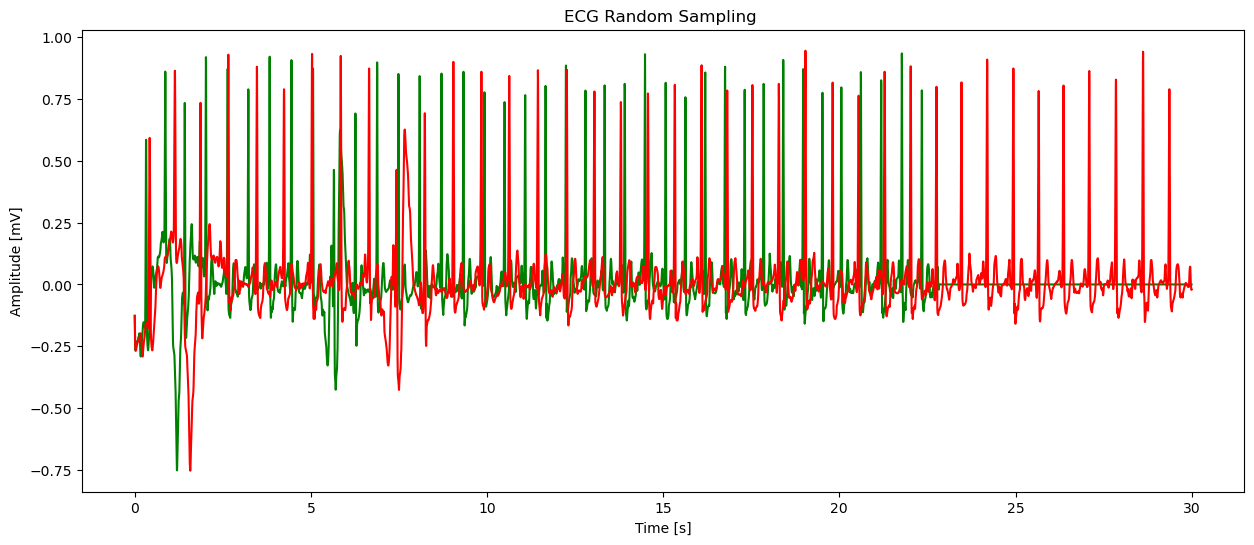

78.7746170678337
67.36526946107784


In [15]:
data_resampled = [] # list for resampled data
ecg_signal, fs = ecg_read('A00001')
data_resampled.append(random_resample(np.expand_dims(ecg_signal, axis = 0))[0])
time = np.arange(0,len(ecg_signal) )/fs
plt.figure(figsize=(15, 6))
plt.plot(time, data_resampled[0], 'g')
plt.plot(time, ecg_signal, 'r')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title(f'ECG Random Sampling ')
plt.show()

hr = calculate_hr_from_ecg(ecg_signal, fs)
hr1 = calculate_hr_from_ecg(data_resampled[0], fs)
print(hr)
print(hr1)

# Plot ECG UI

#### ecg plot function ui

In [16]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
 
  
def plot_ecg_ui(patient_id, ecg_signal, fs):
    def update_plot(start, end):
        start_idx = int(start * fs)
        end_idx = int(end * fs)
        
        selected_ecg_signal = ecg_signal[start_idx:end_idx]
        avg_hr = calculate_hr_from_ecg(selected_ecg_signal, fs)
        
        plt.figure(figsize=(15, 6))
        plt.plot(np.arange(start_idx, end_idx) / fs, selected_ecg_signal, 'g')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.title(f'ECG Time Series - {patient_id} (from {start}s to {end}s) - Avg HR: {avg_hr:.2f} BPM')
        plt.show()

    # 슬라이더 정의
    start_slider = widgets.FloatSlider(min=0, max=len(ecg_signal)/fs, value=0, description='Start Time:')
    end_slider = widgets.FloatSlider(min=0, max=len(ecg_signal)/fs, value=5, description='End Time:')

    # 슬라이더 상호작용 위젯
    ui = widgets.HBox([start_slider, end_slider])
    out = widgets.interactive_output(update_plot, {'start': start_slider, 'end': end_slider})

    display(ui, out)
    
    


### random_sampling function ui

In [17]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

global_processed_ecg_signal = None
def plot_random_ui(patient_id, ecg_signal, fs):
    
    global global_processed_ecg_signal
    ecg_signal=random_resample(np.expand_dims(ecg_signal, axis = 0))[0]
    global_processed_ecg_signal = ecg_signal
    def update_plot(start, end):
        start_idx = int(start * fs)
        end_idx = int(end * fs)
        
        selected_ecg_signal = ecg_signal[start_idx:end_idx]
        avg_hr = calculate_hr_from_ecg(selected_ecg_signal, fs)
        
        plt.figure(figsize=(15, 6))
        plt.plot(np.arange(start_idx, end_idx) / fs, selected_ecg_signal, 'r')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.title(f'ECG Randomsampled - {patient_id} (from {start}s to {end}s) - Avg HR: {avg_hr:.2f} BPM')
        plt.show()

    # 슬라이더 정의
    start_slider = widgets.FloatSlider(min=0, max=len(ecg_signal)/fs, value=0, description='Start Time:')
    end_slider = widgets.FloatSlider(min=0, max=len(ecg_signal)/fs, value=5, description='End Time:')

    # 슬라이더 상호작용 위젯
    ui = widgets.HBox([start_slider, end_slider])
    out = widgets.interactive_output(update_plot, {'start': start_slider, 'end': end_slider})

    display(ui, out)


## Irisgram (STFT.Ver)

In [18]:
from scipy.signal import get_window

def plot_Iris(patient_id, ecg_signal, fs, is_random_resampled=False):
    # 윈도우 길이 정의 (예: 1초 길이)
    window_length_sec = 0.1  # 1초
    window_length_samples = int(fs * window_length_sec)

    # 윈도우 함수 생성 (예: 해밍 윈도우)
    window_type = 'hamming'
    win = get_window(window_type, window_length_samples)



    # STFT 계산
    # window_length = int(0.1 * fs)
    f, t, Zxx = signal.stft(ecg_signal, fs=fs, window=win, nperseg=len(win))

    # 복소수 데이터의 크기 계산
    PSD1 = np.abs(Zxx)

    # Equivalent to Equivalent Noise Bandwidt in MATLAB
    enbw = np.sum(np.square(win)) / len(win)

    # 진폭 스펙트럼으로 변환 (dB)
    S = 20 * np.log10(np.sqrt(PSD1 * enbw) * np.sqrt(2))

    # 극좌표 변환
    theta = -np.linspace(-np.pi, np.pi, len(t))
    rho = np.max(f)/3 + f
    T, R = np.meshgrid(theta, rho)
    X, Y = R * np.cos(T), R * np.sin(T)

    # 동적 범위 제한
    Smax = np.max(S)
    Smin = np.max([np.min(S), Smax - 120])  # 최대 120 dB 동적 범위

    # 이름 설정    
    if is_random_resampled:
            title = f'ECG Irisgram(STFT.Ver) - {patient_id} (Random Resampled)'
    else:
            title = f'ECG Irisgram(STFT.Ver) - {patient_id}'


    # STFT Irisgram
    plt.figure()
    plt.pcolormesh(X, Y, S, shading='gouraud', cmap='jet')
    plt.colorbar(label='Magnitude, dB')
    plt.axis('image')
    plt.axis('off')
    plt.title(title)
    plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.signal import spectrogram, get_window, welch



dic = {'Atrial Fibrillation': A, 'Normal Sinus Rhythm': N, 'Other Rhythm': O, 'Noisy': I}
# 레이블 선택을 위한 드롭다운 위젯
label_dropdown = widgets.Dropdown(
    options=list(dic.keys()),
    description='ECG Label:',
)

# 환자 ID 선택을 위한 두 번째 드롭다운 (초기화는 빈 상태)
patient_dropdown = widgets.Dropdown(
    options=[],
    description='ID:',
)


# Zeropadding 선택을 위한 세 번째 드롭다운
padding_dropdown = widgets.Dropdown(
    options=['N', 'Y'],
    description='Zero-padding:',
)


# PT Algorithm의 디노이징을 선택하기 위한 네 번째 드롭다운
Pan_tompkins_dropdown= widgets.Dropdown(
    options=['N', 'Y'],
    description='Pan_tompkins',
)

# Random-resampling에 대한 다섯 번째 드롭다운
random_resample_dropdown= widgets.Dropdown(
    options=['N', 'Y'],
    description='Random-Resampling',
)

# Random-resampling에 대한 다섯 번째 드롭다운
Irisgram_dropdown= widgets.Dropdown(
    options=['N', 'Y'],
    description='Iris',
)

# 레이블 선택에 따라 환자 ID 드롭다운 옵션을 업데이트하는 함수
def update_patient_dropdown(*args):
    label = label_dropdown.value
    patient_dropdown.options = dic[label]
    


label_dropdown.observe(update_patient_dropdown, 'value')

# HR 차이를 표시하기 위한 레이블
hr_difference_label = widgets.Label()

# 환자 ID가 선택되었을 때 ECG를 플롯하는 함수
def on_patient_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(widgets.HBox([label_dropdown, patient_dropdown]))
        display(widgets.HBox([padding_dropdown, Pan_tompkins_dropdown,random_resample_dropdown, Irisgram_dropdown]))
        display(hr_difference_label)
        patient_id = change['new']
        
        # ecg read
        ecg_signal, fs = ecg_read(patient_id)
        
        plot_ecg_ui(patient_id, ecg_signal, fs)
        

def on_ecgprocess_dropdown_change(change):
            if change['type'] == 'change' and change['name'] == 'value':
                clear_output(wait=True)
                display(widgets.HBox([label_dropdown, patient_dropdown]))
                display(widgets.HBox([padding_dropdown, Pan_tompkins_dropdown, random_resample_dropdown, Irisgram_dropdown]))
                display(hr_difference_label)
                patient_id = patient_dropdown.value
                
                # ecg read
                ecg_signal, fs = ecg_read(patient_id)

                # Zero Padding 적용 여부 확인
                if padding_dropdown.value == 'Y':
                    # maxtime_length를 적절히 정의해야 합니다.
                    ecg_signal = extend_ts(ecg_signal, maxtime_length)

                # Pan-Tompkins 디노이징 적용 여부 확인
                if Pan_tompkins_dropdown.value == 'Y':
                    pan_tompkins = Pan_tompkins(ecg_signal, fs)
                    ecg_signal = pan_tompkins.fit()
            
                # ECG 신호 플롯
                plot_ecg_ui(patient_id, ecg_signal, fs)
             
                # Random sampling 결과 출력 여부 확인
                if random_resample_dropdown.value == 'Y':
                    hr= calculate_hr_from_ecg(ecg_signal, fs)
                    plot_random_ui(patient_id, ecg_signal, fs)
                    hr1 = calculate_hr_from_ecg(global_processed_ecg_signal, fs)
                    hr_difference_label.value = f"HR difference for Max time: {hr1 - hr:.2f} BPM"
                    
                    # Random sampling의 Irisgram 출력 여부 확인
                    if Irisgram_dropdown.value == 'Y':
                        plot_Iris(patient_id, ecg_signal, fs, is_random_resampled= True)  
                
                # Random sampling 결과 출력 여부 확인
                if Irisgram_dropdown.value == 'Y':
                    plot_Iris(patient_id, ecg_signal, fs, is_random_resampled= False)      
        
    
patient_dropdown.observe(on_patient_dropdown_change, 'value')
padding_dropdown.observe(on_ecgprocess_dropdown_change, 'value')
Pan_tompkins_dropdown.observe(on_ecgprocess_dropdown_change, 'value')
random_resample_dropdown.observe(on_ecgprocess_dropdown_change, 'value')
Irisgram_dropdown.observe(on_ecgprocess_dropdown_change, 'value')

# 위젯 표시
display(widgets.HBox([label_dropdown, patient_dropdown]))






Label(value='HR difference for Max time: -1.54 BPM')

Output()